# Reinforcement learning for legged robots

## Setup

Before we start, you will need to update your conda environment to use Gymnasium (maintained) rather than OpenAI Gym (discontinued). You can simply run:

```
conda activate robotics-mva
conda install -c conda-forge gymnasium imageio mujoco=2.3.7 stable-baselines3 tensorboard
```

Import Gymnasium and Stable Baselines3 to check that everything is working:

Let's import the usual suspects as well:

In [241]:
import matplotlib.pylab as plt
import numpy as np
import gymnasium as gym
import stable_baselines3

plt.ion()

# Inverted pendulum environment

The inverted pendulum model is not just a toy model reproducing the properties of real robot models for balancing: as it turns out, the inverted pendulum appears in the dynamics of *any* mobile robot, that is, a model with a floating-base joint at the root of the kinematic tree. (If you are curious: the inverted pendulum is a limit case of the [Newton-Euler equations](https://scaron.info/robotics/newton-euler-equations.html) corresponding to floating-base coordinates in the equations of motion $M \ddot{q} + h = S^T \tau + J_c^T f$, in the limit where the robot [does not vary its angular momentum](https://scaron.info/robotics/point-mass-model.html).) Thus, while we work on a simplified inverted pendulum in this notebook, concepts and tools are those used as-is on real robots, as you can verify by exploring the bonus section.

Gymnasium is mainly a single-agent reinforcement learning API, but it also comes with simple environments, including an inverted pendulum sliding on a linear guide:

In [242]:
with gym.make("InvertedPendulum-v4", render_mode="human") as env:
    action = 0 * env.action_space.sample()
    observation, _ = env.reset()
    episode_return = 0.0
    for step in range(200):
        action[0] = 5.0 * observation[1] + 0.3 * observation[0]
        observation, reward, terminated, truncated, _ = env.step(action)
        episode_return += reward
        if terminated or truncated:
            observation, _ = env.reset()
    print(f"Return of the episode: {episode_return}")

Return of the episode: 200.0


The structure of the action and observation vectors are documented in [Inverted Pendulum - Gymnasium Documentation](https://gymnasium.farama.org/environments/mujoco/inverted_pendulum/).  The observation, in particular, is a NumPy array with four coordinates that we recall here for reference:

| Num | Observation | Min | Max | Unit |
|-----|-------------|-----|-----|------|
|   0 | position of the cart along the linear surface | -Inf | Inf | position (m) |
|   1 | vertical angle of the pole on the cart | -Inf | Inf | angle (rad) |
|   2 | linear velocity of the cart | -Inf | Inf | linear velocity (m/s) |
|   3 | angular velocity of the pole on the cart | -Inf | Inf | anglular velocity (rad/s) |

We will use the following labels to annotate plots:

In [243]:
OBSERVATION_LEGEND = ("pitch", "position", "linear_velocity", "angular_velocity")

Check out the documentation for the definitions of the action and rewards.

# PID control

A *massively* used class of policies is the [PID controller](https://en.wikipedia.org/wiki/Proportional%E2%80%93integral%E2%80%93derivative_controller). Let's say we have a reference observation, like $o^* = [0\ 0\ 0\ 0]$ for the inverted pendulum. Denoting by $e(t) = o^* - o(t)$ the *error* of the system when it observes a given state, a continuous-time PID controller will apply the action:

$$
a(t) = K_p^T e(t) + K_d^T \dot{e}(t) + K_i^T \int e(\tau) \mathrm{d} \tau
$$

where $K_{p}, K_i, K_d \in \mathbb{R}^4$ are constants called *gains* and tuned by the user. In discrete time the idea is the same:

$$
a_k = K_p^T e_k + K_d^T \frac{e_k - e_{k-1}}{\delta t} + K_i^T \sum_{i=0}^{k} e_i {\delta t}
$$

Since $o^* = 0$ for all t, one can re-write as such :
$$
a_k = -K_p^T o_k - K_d^T \frac{o_k - o_{k-1}}{\delta t} - K_i^T \sum_{i=0}^{k} o_i {\delta t}
$$

Let's refactor the rolling out of our episode into a standalone function:

In [293]:
def rollout_from_env(env, policy):
    episode = []
    observation, _ = env.reset()
    episode.append(observation)
    observation_cumul= observation
    arr = observation.__array__()
    for step in range(1000):
        action = policy(observation)
        observation_prev = observation #To make the finite difference for K_d
        observation, reward, terminated, truncated, _ = env.step(action)
        observation_cumul += observation #To make the sum for K_i
        episode.extend([action, reward, observation])
        if terminated or truncated:
            return episode
    return episode

def rollout(policy, show: bool = True):
    kwargs = {"render_mode": "human"} if show else {}
    with gym.make("InvertedPendulum-v4", **kwargs) as env:
        episode = rollout_from_env(env, policy)
    return episode

## Question 1: Write a PID controller that balances the inverted pendulum

You can use global variables to store the (discrete) derivative and integral terms, this will be OK here as we only rollout a single trajectory:

In [297]:
dt = 0.02
K_i = [-12.561808137454825, -12.14739814239248, 2.690148998387749, 12.668066397249083]
K_d = [-3.793784507151475, -13.188985560584737, 14.434076771424781, 2.3698959363014764]
K_p = [-4.078440175942435, 12.4312114536961, 4.741317143431328, 8.387021131458233]
observation_prev = np.zeros((4))

def pid_policy(observation: np.ndarray) -> np.ndarray:
   # observation_cumul += observation
    o_p = observation_cumul2*dt
    o_d = (observation - observation_prev)/dt 
    my_action_value: float = - np.dot(K_p,observation) - np.dot(K_d, o_d) - np.dot(o_p, K_p) # your action here
   # observation_prev = observation
    return np.array([my_action_value])

episode = rollout(pid_policy, show=True)

c:\Users\hugon\anaconda3\envs\robotics-mva\lib\site-packages\glfw\__init__.py:916: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)
Exception ignored in: <function WindowViewer.__del__ at 0x00000206A9482440>
Traceback (most recent call last):
  File "c:\Users\hugon\anaconda3\envs\robotics-mva\lib\site-packages\gymnasium\envs\mujoco\mujoco_rendering.py", line 335, in __del__
    self.free()
  File "c:\Users\hugon\anaconda3\envs\robotics-mva\lib\site-packages\gymnasium\envs\mujoco\mujoco_rendering.py", line 330, in free
    glfw.destroy_window(self.window)
  File "c:\Users\hugon\anaconda3\envs\robotics-mva\lib\site-packages\glfw\__init__.py", line 1281, in destroy_window
    window_addr = ctypes.cast(ctypes.pointer(window),
TypeError: _type_ must have storage info


You can look at the system using `show=True`, but intuition usually builds faster when looking at relevant plots:

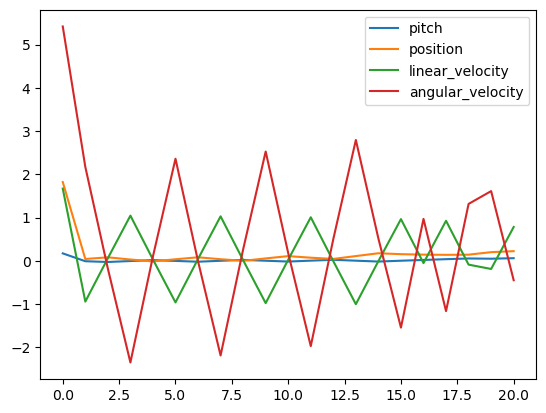

In [284]:
observations = np.array(episode[::3])

plt.plot(observations)
plt.legend(OBSERVATION_LEGEND)

Can you reach the full reward of 1000 steps?

In [285]:
print(f"Return of the episode: {sum(episode[2::3])}")

Return of the episode: 20.0


# Policy optimization

Let us now train a policy, parameterized by a multilayer perceptron (MLP), to maximize the expected return over episodes on the inverted pendulum environment.

## Our very first policy

We will use the proximal policy optimization (PPO) algorithm for training, using the implementation from Stable Baselines3: [PPO - Stable Baselines3 documentation](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html).

In [248]:
from stable_baselines3 import PPO

with gym.make("InvertedPendulum-v4", render_mode="human") as env:
    first_policy = PPO("MlpPolicy", env, verbose=0)
    first_policy.learn(total_timesteps=1000, progress_bar=False)

Exception ignored in: <function WindowViewer.__del__ at 0x00000206A9482440>
Traceback (most recent call last):
  File "c:\Users\hugon\anaconda3\envs\robotics-mva\lib\site-packages\gymnasium\envs\mujoco\mujoco_rendering.py", line 335, in __del__
    self.free()
  File "c:\Users\hugon\anaconda3\envs\robotics-mva\lib\site-packages\gymnasium\envs\mujoco\mujoco_rendering.py", line 330, in free
    glfw.destroy_window(self.window)
  File "c:\Users\hugon\anaconda3\envs\robotics-mva\lib\site-packages\glfw\__init__.py", line 1281, in destroy_window
    window_addr = ctypes.cast(ctypes.pointer(window),
TypeError: _type_ must have storage info
Exception ignored in: <function WindowViewer.__del__ at 0x00000206A9482440>
Traceback (most recent call last):
  File "c:\Users\hugon\anaconda3\envs\robotics-mva\lib\site-packages\gymnasium\envs\mujoco\mujoco_rendering.py", line 335, in __del__
    self.free()
  File "c:\Users\hugon\anaconda3\envs\robotics-mva\lib\site-packages\gymnasium\envs\mujoco\mujoco_

By instantiating the algorithm with no further ado, we let the library decide for us on a sane set of default hyperparameters, including:

- Rollout buffers of `n_steps = 2048` steps, which we will visit `n_epochs = 10` times with mini-batches of size `batch_size = 64`.
- Clipping range: ``0.2``.
- No entropy regularization.
- Learning rate for the Adam optimizer: ``3e-4``
- Policy and value-function network architectures: two layers of 64 neurons with $\tanh$ activation functions.

We then called the `learn` function to execute PPO over a fixed total number of timesteps, here just a thousand.

Rendering actually took a significant chunk of time. Let's instantiate and keep an environment open without rendering:

In [249]:
env = gym.make("InvertedPendulum-v4")

We can use it to train much more steps in roughly the same time, reporting training metrics every `n_steps` step:

In [250]:
second_policy = PPO("MlpPolicy", env, verbose=1)
second_policy.learn(total_timesteps=10_000, progress_bar=False)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.66     |
|    ep_rew_mean     | 8.66     |
| time/              |          |
|    fps             | 1213     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 11.3        |
| time/                   |             |
|    fps                  | 899         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.020673957 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss   

Let's see how this policy performs:

In [251]:
def policy_closure(policy):
    """Utility function to turn our policy instance into a function.

    Args:
        policy: Policy to turn into a function.
        
    Returns:
        Function from observation to policy action.
    """
    def policy_function(observation):
        action, _ = policy.predict(observation)
        return action
    return policy_function

In [252]:
episode = rollout(policy_closure(second_policy), show=True)

[-0.00249026 -0.00349212 -0.00656391 -0.00498081]
[ 0.00328037 -0.01765445  0.29428749 -0.69621125]
[ 0.00455013 -0.02085651 -0.22884942  0.51838817]
[-5.08130949e-03  1.23577865e-04 -2.53089384e-01  5.34536348e-01]
[-0.01524103  0.02109476 -0.25531793  0.51840252]
[-0.02041033  0.03008859 -0.00422814 -0.05876156]
[-0.02927959  0.04845444 -0.43793983  0.96605172]
[-0.03533135  0.06061597  0.13302209 -0.33693302]
[-0.03182333  0.05277872  0.04293149 -0.06028962]
[-0.01819049  0.02392485  0.6373405  -1.37027848]
[ 0.00073553 -0.01390554  0.31091657 -0.54025985]
[ 0.00704292 -0.02105099  0.00570025  0.17154022]
[ 0.00167242 -0.00178006 -0.27364231  0.78721686]
[-0.00900279  0.02830689 -0.26077803  0.72396485]
[-0.00979522  0.03484752  0.21929728 -0.38003646]
[-0.00121013  0.0211132   0.21031577 -0.31035453]
[ 0.00187331  0.02172382 -0.05516576  0.33199815]
[-0.00575446  0.04761643 -0.32569361  0.95875077]
[-0.00832501  0.06180289  0.19497057 -0.22957267]
[ 0.00365271  0.04436055  0.403630

Exception ignored in: <function WindowViewer.__del__ at 0x00000206A9482440>
Traceback (most recent call last):
  File "c:\Users\hugon\anaconda3\envs\robotics-mva\lib\site-packages\gymnasium\envs\mujoco\mujoco_rendering.py", line 335, in __del__
    self.free()
  File "c:\Users\hugon\anaconda3\envs\robotics-mva\lib\site-packages\gymnasium\envs\mujoco\mujoco_rendering.py", line 330, in free
    glfw.destroy_window(self.window)
  File "c:\Users\hugon\anaconda3\envs\robotics-mva\lib\site-packages\glfw\__init__.py", line 1281, in destroy_window
    window_addr = ctypes.cast(ctypes.pointer(window),
TypeError: _type_ must have storage info


[0.72194239 0.11012148 0.53377126 0.95898741]
[0.74336212 0.14939944 0.53658611 1.01181585]
[ 0.77467806  0.1691399   1.0269922  -0.00546093]
[0.80934054 0.18660607 0.70732154 0.86917316]
[ 0.85431037  0.18611074  1.53851986 -0.86985182]
[ 0.91483377  0.15787293  1.48849057 -0.55147505]
[0.97075205 0.14750284 1.30838523 0.02329514]
[1.01323126 0.17369425 0.43978413 2.14155701]
[ 1.01644433  0.29287065 -0.11108198  3.43152207]


Okay, it looks like we didn't train for long enough!

## Monitoring performance during training

Let's train for longer, and use TensorBoard to keep track. We don't know how long training will take so let's put a rather large total number of steps (you can interrupt training once you observed convergence in TensorBoard):

In [257]:
erudite_policy = PPO(
    "MlpPolicy",
    env,
    tensorboard_log="./inverted_pendulum_tensorboard/",
    verbose=0,
)

erudite_policy.learn(
    total_timesteps=1_000_000,
    progress_bar=False,
    tb_log_name="erudite",
)

Run TensorBoard on the directory thus created to open a dashboard in your Web browser:

```
tensorboard --logdir ./inverted_pendulum_tensorboard/
```

The link will typically be http://localhost:6006 (port number increases if you run TensorBoard multiple times in parallel). Tips:

- Click the Settings icon in the top-right corner and enable "Reload data"
- Uncheck "Ignore outliers in chart scaling" (your preference)

## Saving our policy

Now that you spent some computing to optimize an actual policy, better save it to disk:

You can then reload it later by:

In [259]:
erudite_policy = PPO.load("pendulum_erudite", env=env)

In [260]:
episode = rollout(policy_closure(erudite_policy), show=True)

[-0.00927072  0.00795247 -0.00228131  0.00521712]
[-0.00946401  0.00856606 -0.00736607  0.025307  ]
[-0.00960616  0.00938671  0.00022635  0.01602404]
[-0.00925369  0.00941911  0.01734751 -0.01397073]
[-0.00872065  0.0094465   0.00934644  0.01494532]
[-0.00812662  0.00972252  0.02032318 -0.00086182]
[-0.00673845  0.00856677  0.04901893 -0.0563704 ]
[-0.00477968  0.00655754  0.04897373 -0.04464937]
[-0.00263614  0.00453826  0.05822141 -0.05654431]
[ 0.00017197  0.00133768  0.08217167 -0.10345899]
[ 0.00315566 -0.00194411  0.0671389  -0.06186401]
[ 0.00582971 -0.00433622  0.06661485 -0.05826718]
[ 0.00819773 -0.00597293  0.05187056 -0.02437097]
[ 0.01055709 -0.00765904  0.06607569 -0.05977414]
[ 0.01310222 -0.00987367  0.06123715 -0.05151614]
[ 0.01546922 -0.01184186  0.05715884 -0.04734701]
[ 0.01761267 -0.01354353  0.05006266 -0.0382078 ]
[ 0.01907453 -0.01400084  0.02312301  0.01450514]
[ 0.01970247 -0.0129726   0.00829177  0.03679184]
[ 0.01980513 -0.01121316 -0.00316746  0.05132003]


Exception ignored in: <function WindowViewer.__del__ at 0x00000206A9482440>
Traceback (most recent call last):
  File "c:\Users\hugon\anaconda3\envs\robotics-mva\lib\site-packages\gymnasium\envs\mujoco\mujoco_rendering.py", line 335, in __del__
    self.free()
  File "c:\Users\hugon\anaconda3\envs\robotics-mva\lib\site-packages\gymnasium\envs\mujoco\mujoco_rendering.py", line 330, in free
    glfw.destroy_window(self.window)
  File "c:\Users\hugon\anaconda3\envs\robotics-mva\lib\site-packages\glfw\__init__.py", line 1281, in destroy_window
    window_addr = ctypes.cast(ctypes.pointer(window),
TypeError: _type_ must have storage info


## Question 2: How many steps does it take to train a successful policy?

We consider a policy successful if it consistently achieves the maximum return of 1000.

## A more realistic environment

Real systems suffer from the two main issues we saw in the [Perception and estimation](https://scaron.info/robotics-mva/#5-perception-estimation) class: *bias* and *variance*. In this section, we model bias in actuation and perception by adding delays (via low-pass filtering) to respectively the action and observation vectors. Empirically this is an effective model, as for instance it contributes to sim2real transfer on Upkie. To add these delays, we use an [`environment wrapper`](https://gymnasium.farama.org/api/wrappers/), which is a convenient way to compose environments, used in both the Gymnasium and Stable Baselines3 APIs:

In [346]:

class DelayWrapper(gym.Wrapper):
    def __init__(self, env, time_constant: float = 0.2):
        """Wrap environment with some actuation and perception modeling.

        Args:
            env: Environment to wrap.
            time_constant: Constant of the internal low-pass filter, in seconds.
                Feel free to play with different values but leave it to the default
                of 0.2 seconds when handing out your homework.

        Note:
            Delays are implemented by a low-pass filter. The same time constant
            is used for both actions and observations, which is not realistic, but
            makes for less tutorial code ;)
        """
        alpha = env.dt / time_constant
        assert 0.0 < alpha < 1.0
        super().__init__(env)
        self._alpha = alpha
        self._prev_action = 0.0 * env.action_space.sample()
        self._prev_observation = np.zeros(4)

    def low_pass_filter(self, old_value, new_value):
        return old_value + self._alpha * (new_value - old_value)

    def step(self, action):
        new_action = self.low_pass_filter(self._prev_action, action)
        observation, reward, terminated, truncated, info = self.env.step(new_action)
        new_observation = self.low_pass_filter(self._prev_observation, observation)
        self._prev_action = new_action
        self._prev_observation = new_observation
        return new_observation, reward, terminated, truncated, info


delay_env = DelayWrapper(env)
delay_env_stack = gym.wrappers.FrameStack(delay_env,15) #The ten most recent observations

We can check how our current policy fares against the delayed environment. Spoiler alert: no great.

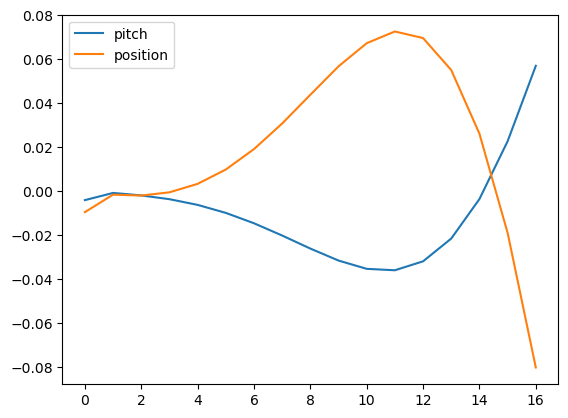

In [ ]:
delay_episode = rollout_from_env(delay_env, policy_closure(erudite_policy))
observations = np.array(delay_episode[::3])

plt.plot(observations[:, :2])
plt.legend(OBSERVATION_LEGEND)

## Question 3: Can't we just re-train a policy on the new environment?

At this point of the tutorial this is a rethorical question, but we should check anyway. Re-train a policy on the delayed environment and comment on its performance:

In [ ]:
erudite_policy_delay = PPO(
    "MlpPolicy",
    delay_env,
    tensorboard_log="./inverted_pendulum_tensorboard/",
    verbose=0,
)

erudite_policy_delay.learn(
    total_timesteps=1_000_000,
    progress_bar=False,
    tb_log_name="erudite",
)

In [ ]:
erudite_policy = PPO.load("pendulum_erudite", env=env)

In [317]:
episode = rollout(policy_closure(erudite_policy_delay), show=True)

c:\Users\hugon\anaconda3\envs\robotics-mva\lib\site-packages\glfw\__init__.py:916: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)
Exception ignored in: <function WindowViewer.__del__ at 0x00000206A9482440>
Traceback (most recent call last):
  File "c:\Users\hugon\anaconda3\envs\robotics-mva\lib\site-packages\gymnasium\envs\mujoco\mujoco_rendering.py", line 335, in __del__
    self.free()
  File "c:\Users\hugon\anaconda3\envs\robotics-mva\lib\site-packages\gymnasium\envs\mujoco\mujoco_rendering.py", line 330, in free
    glfw.destroy_window(self.window)
  File "c:\Users\hugon\anaconda3\envs\robotics-mva\lib\site-packages\glfw\__init__.py", line 1281, in destroy_window
    window_addr = ctypes.cast(ctypes.pointer(window),
TypeError: _type_ must have storage info


## The Real Question 3: Why do delays degrade both runtime and training performance?

Loss in runtime performance refers to the one we observed when executing a policy trained without delay on an environment with delays. Loss in training performance refers to the fact that, even when we train a new policy on the environment with delays, by the end of training it does not achieve maximum return.

Propose and implement a way to overcome this. Train the resulting policy in a variable called `iron_policy`.

In [353]:
iron_policy_15 = PPO(
    "MlpPolicy",
    delay_env_stack,
    tensorboard_log="./inverted_pendulum_tensorboard/",
    verbose=0,
)

iron_policy_15.learn(
    total_timesteps=1_000_000,
    progress_bar=False,
    tb_log_name="erudite",
)

In [354]:
iron_policy.save("iron_policy_15")

In [372]:
iron_policy = iron_policy.load("iron_policy_15")
delay_env_stack = gym.wrappers.FrameStack(delay_env,10) #The ten most recent observations

In [357]:
def rollout_from_env2(env, policy):
    episode = []
    observation, _ = env.reset()
    episode.append(observation)
    for step in range(1000):
        action = policy(observation)
        observation, reward, terminated, truncated, _ = env.step(action)
        episode.extend([action, reward, observation])
        if terminated or truncated:
            return episode
    return episode

def rollout2(policy, show: bool = True):
    kwargs = {"render_mode": "human"} if show else {}
    with delay_env_stack as env:
        episode = rollout_from_env2(env, policy)
    return episode

Roll out an episode and plot the outcome to show that your policy handles delays properly.

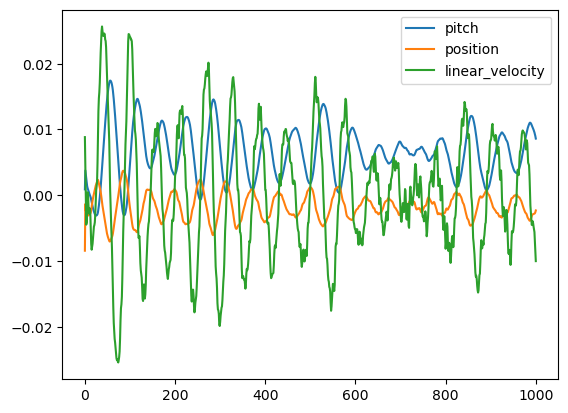

In [386]:
episode_stack = rollout2(policy_closure(iron_policy), show = True)

observations_stack = np.array(episode_stack[::3])
observations_stack = observations_stack[:,-1]
plt.plot(np.array(observations_stack)[:, :3])
plt.legend(OBSERVATION_LEGEND)

## Question 4: Can you improve sampling efficiency?

This last question is open: what can you change in the pipeline to train a policy that achieves maximum return using less samples? Report on at least one thing that allowed you to train with less environment steps.

Here is a state-of-the-art™ utility function if you want to experiment with scheduling some of the ``Callable[[float], float]`` [hyperparameters](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html#parameters):

In [ ]:
def affine_schedule(y_0: float, y_1: float):
    """Affine schedule as a function over the [0, 1] interval.

    Args:
        y_0: Function value at zero.
        y_1: Function value at one.
        
    Returns:
        Corresponding affine function.
    """
    def schedule(x: float) -> float:
        return y_0 + x * (y_1 - y_0)
    return schedule

And here is a wrapper template if you want to experiment with reward shaping:

In [ ]:
class CustomRewardWrapper(gym.Wrapper):
   def __init__(self, env):
       super().__init__(env)

   def step(self, action):
       observation, reward, terminated, truncated, info = self.env.step(action)
       new_reward = 0.0  # your formula here
       return observation, new_reward, terminated, truncated, info

# Bonus: training a policy for a real robot

This section is entirely optional and will only work on Linux or macOS. In this part, we follow the same training pipeline but with the open source software of [Upkie](https://hackaday.io/project/185729-upkie-wheeled-biped-robots).

## Setup

<img src="https://user-images.githubusercontent.com/1189580/170496331-e1293dd3-b50c-40ee-9c2e-f75f3096ebd8.png" style="height: 100px" align="right" />

First, make sure you have a C++ compiler (setup one-liners: [Fedora](https://github.com/upkie/upkie/discussions/100), [Ubuntu](https://github.com/upkie/upkie/discussions/101)). You can run an Upkie simulation right from the command line. It won't install anything on your machine, everything will run locally from the repository:

```console
git clone https://github.com/upkie/upkie.git
cd upkie
git checkout fb9a0ab1f67a8014c08b34d7c0d317c7a8f71662
./start_simulation.sh
```

**NB:** this tutorial is written for the specific commit checked out above. If some instructions don't work it's likely you forgot to check it out.

We will use the Python API of the robot to test things from this notebook, or from custom scripts. Install it from PyPI in your Conda environment:

```
pip install upkie
```

## Stepping the environment

If everything worked well, you should be able to step an environment as follows:

In [ ]:
import gymnasium as gym
import upkie.envs

upkie.envs.register()

episode_return = 0.0
with gym.make("UpkieGroundVelocity-v1", frequency=200.0) as env:
    observation, _ = env.reset()  # connects to the spine (simulator or real robot)
    action = 0.0 * env.action_space.sample()
    for step in range(1000):
        pitch = observation[0]
        action[0] = 10.0 * pitch  # 1D action: [ground_velocity]
        observation, reward, terminated, truncated, _ = env.step(action)
        episode_return += reward
        if terminated or truncated:
            observation, _ = env.reset()

print(f"We have stepped the environment {step + 1} times")
print(f"The return of our episode is {episode_return}")

(If you see a message "Waiting for spine /vulp to start", it means the simulation is not running.)

We can double-check the last observation from the episode:

In [ ]:
def report_last_observation(observation):
    print("The last observation of the episode is:")
    print(f"- Pitch from torso to world: {observation[0]:.2} rad")
    print(f"- Ground position: {observation[1]:.2} m")
    print(f"- Angular velocity from torso to world in torso: {observation[2]:.2} rad/s")
    print(f"- Ground velocity: {observation[3]:.2} m/s")
    
report_last_observation(observation)

## Question B1: PID control

Adapt your code from Question 1 to this environment:

In [ ]:
def policy_b1(observation):
    return np.array([0.0])  # replace with your solution


def run(policy, nb_steps: int):
    episode_return = 0.0
    with gym.make("UpkieGroundVelocity-v1", frequency=200.0) as env:
        observation, _ = env.reset()  # connects to the spine (simulator or real robot)
        for step in range(nb_steps):
            action = policy_b1(observation)
            observation, reward, terminated, truncated, _ = env.step(action)
            if terminated or truncated:
                print("Fall detected!")
                return episode_return
    report_last_observation(observation)
    return episode_return


episode_return = run(policy_b1, 1000)
print(f"The return of our episode is {episode_return}")

## Training a new policy

The Upkie repository ships three agents based on PID control, model predictive control and reinforcement learning. We now focus on the latter, called the "PPO balancer".

Check that you can run the training part by running, from the root of the repository:

```
./tools/bazel run //agents/ppo_balancer:train -- --nb-envs 1 --show
```

A simulation window should pop, and verbose output from SB3 should be printed to your terminal.

By default, training data will be logged to `/tmp`. You can select a different output path by setting the `UPKIE_TRAINING_PATH` environment variable in your shell. For instance:

```
export UPKIE_TRAINING_PATH="${HOME}/src/upkie/training"
```

Run TensorBoard from the training directory:

```
tensorboard --logdir ${UPKIE_TRAINING_PATH}  # or /tmp if you keep the default
```

Each training will be named after a word picked at random in an English dictionary.

## Selecting the number of processes

We can increase the number of parallel CPU environments ``--nb-envs`` to a value suitable to your computer. Let training run for a minute and check `time/fps`. Increase the number of environments and compare the stationary regime of `time/fps`. You should see a performance increase when adding the first few environments, followed by a declined when there are two many parallel processes compared to your number of CPU cores. Pick the value that works best for you.

## Running a trained policy

Copy the file `final.zip` from your trained policy directory to `agents/ppo_balancer/policy/params.zip`. Start a simulation and run the policy by:

```
./tools/bazel run //agents/ppo_balancer
```

What kind of behavior do you observe?

## Question B2: Improve this baseline

The policy you are testing here is not the one we saw in class. Open question: improve on it using any of the methods we discussed. Measure the improvement by `ep_len_mean` or any other quantitative criterion: